In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import os

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [3]:
# Define transforms for dataset

trainTransforms = T.Compose({
    T.RandomHorizontalFlip(),
    T.RandomApply([T.RandomResizedCrop(224, scale=(0.8, 1.0))], p=0.3),
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
})

validTransforms = T.Compose({
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
})

testTransforms = T.Compose({
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
})

In [4]:
# Loading dataset
rootPath = '/content/drive/MyDrive/DataSets/Birds'
trainPath = os.path.join(rootPath, 'train')
testPath = os.path.join(rootPath, 'test')
validPath = os.path.join(rootPath, 'valid')

if not (os.path.exists(trainPath) and os.path.exists(testPath) and os.path.exists(validPath)):
  print('Could not find dataset')

trainSet = dset.ImageFolder(trainPath, trainTransforms)
validSet = dset.ImageFolder(validPath, validTransforms)
testSet = dset.ImageFolder(testPath, testTransforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


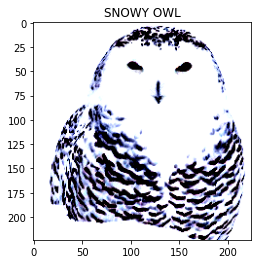

In [5]:
x, y = trainSet[40000]

className = list(trainSet.class_to_idx.keys())[list(trainSet.class_to_idx.values()).index(y)] # Get name of class
plt.title(className)
plt.imshow(x.permute(1, 2, 0))

In [6]:
trainLoader = DataLoader(trainSet, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, trainSet.__len__())))
validLoader = DataLoader(validSet, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, validSet.__len__())))
testLoader = DataLoader(validSet, batch_size=64)

In [33]:
a, _ = next(iter(trainLoader))

In [34]:
a = flatten(a)

In [35]:
a.shape

torch.Size([64, 150528])

In [7]:
def flatten(X):
  """
  Flatten an image to vector
  """
  N = X.shape[0] # Num in batch
  return X.view(N, -1)

class Flatten(nn.Module):
  def forward(self, X):
    return flatten(X)

In [8]:
def check_accuracy(model, dataLoader, typeOfCheck, device=torch.device('cpu')):
  """
  Checking accuracy on given dataSet in dataLoader
  typeOfCheck - train, validation or test
  """
  model = model.to(device=device)

  typeOfCheck = str.lower(typeOfCheck)

  model.eval()

  num_samples = 0
  num_correct = 0

  with torch.no_grad():
    for i, (x, y) in enumerate(dataLoader):
      x = x.to(device=device, dtype=torch.float32)
      y = y.to(device=device, dtype=torch.long)

      scores = model(x)
      _, preds = scores.max(1)

      num_samples += preds.shape[0]
      num_correct += (preds == y).sum()

      if typeOfCheck == 'train' and i == 100: # Чтобы проверяться не на всём огромном train сете (16 * 64 = 1024 как и у validation)
        break

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f) in %s'% (num_correct, num_samples, 100 * acc, typeOfCheck))
    return acc

In [9]:
def train_model(model, optimizer, trainLoader, validationLoader, num_epoch=1, device=torch.device('cpu'), printAndSaveEvery=100, continueTraining=None, savePath = '/content/drive/MyDrive/'):
  
  import torch.nn.functional as F

  if continueTraining is None:
    print("Starting new training")
    best_acc = 0
    train_accuracies = []
    val_accuracies = []
    start_ep = 0
  else:
    train_accuracies = continueTraining['train_accs']
    val_accuracies = continueTraining['val_accs']
    start_ep = continueTraining['num_ep']
    best_acc = val_accuracies[-1]
    print("Continue training from " + str(start_ep) + " epoch")

  model = model.to(device=device)

  for e in range(start_ep, num_epoch):
    print("Start " + str(e) + " epoch")
    for t, (x, y) in enumerate(trainLoader):

      model.train()
      x = x.to(device=device, dtype=torch.float32)
      y = y.to(device=device, dtype=torch.long)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if t % printAndSaveEvery == 0 and t != 0:
        print("Iteration " + str(t) + ":")
        train_acc = check_accuracy(model, trainLoader, 'train', device)
        val_acc = check_accuracy(model, validationLoader, 'validation', device)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        if best_acc < val_acc:
          print("Goten new best val accuracy. Save new best model")
          best_acc = val_acc
          torch.save({
              'Model_state_dict': model.state_dict(),
              'Optimizer_state_dict': optimizer.state_dict(),
              'Num_epoch': e,
              'Train_accs': train_accuracies,
              'Val_accs': val_accuracies
          }, savePath + '/best_model.pt')
          

    train_acc = check_accuracy(model, trainLoader, 'train', device)
    val_acc = check_accuracy(model, validationLoader, 'validation', device)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    torch.save({
        'Model_state_dict': model.state_dict(),
        'Optimizer_state_dict': optimizer.state_dict(),
        'Num_epoch': e + 1,
        'Train_accs': train_accuracies,
        'Val_accs': val_accuracies
    }, savePath + '/model.pt')

  return(train_accuracies, val_accuracies)

In [27]:
len(trainSet.classes)

325

In [39]:
def createModel():
  model = None
  optimizer = None

  input_channels = 3
  channel_1 = 64
  channel_2 = 128
  channel_3 = 256
  channel_4 = 512
  dense_1 = 1024
  dense_2 = 512
  num_classes = 325

  learning_rate = 1e-4
  weight_decay = 1e-5

  model = nn.Sequential(
      
      nn.Conv2d(in_channels=input_channels, out_channels=channel_1, kernel_size=5, stride=1, padding=2), # 224 x 224 x 128
      nn.BatchNorm2d(num_features=channel_1),
      nn.ReLU(),

      # nn.Conv2d(channel_1, channel_1, 5, 1, 2), # 224 x 224 x 64
      # nn.BatchNorm2d(num_features=channel_2),
      # nn.ReLU(),

      nn.MaxPool2d(kernel_size=2, stride=2), # 112 x 112 x 64

      nn.Conv2d(channel_1, channel_2, kernel_size=3, stride=1, padding=1), # 112 x 112 x 128
      nn.BatchNorm2d(num_features=channel_2),
      nn.ReLU(),

      # nn.Conv2d(channel_2, channel_2, kernel_size=3, stride=1, padding=1), # 112 x 112 x 128
      # nn.BatchNorm2d(num_features=channel_4),
      # nn.ReLU(),

      nn.MaxPool2d(kernel_size=2, stride=2), # 64 x 64 x 128

      nn.Conv2d(channel_2, channel_3, kernel_size=3, stride=1, padding=1), # 64 x 64 x 256
      nn.BatchNorm2d(num_features=channel_3),
      nn.ReLU(),
      
      nn.MaxPool2d(kernel_size=2, stride=2), # 32 x 32 x 256

      nn.Conv2d(channel_3, channel_3, kernel_size=3, stride=1, padding=1), # 32 x 32 x 256
      nn.BatchNorm2d(num_features=channel_3),
      nn.ReLU(),
      
      nn.MaxPool2d(kernel_size=2, stride=2), # 16 x 16 x 256
      
      nn.Conv2d(channel_3, channel_3, kernel_size=3, stride=1, padding=1), # 16 x 16 x 256
      nn.BatchNorm2d(num_features=channel_3),
      nn.ReLU(),
      
      nn.MaxPool2d(kernel_size=2, stride=2), # 8 x 8 x 256

      #Flatten()#,
      # nn.Linear(8 * 8 * 256, dense_1), # 
      # nn.ReLU(),
      # nn.Linear(dense_1, dense_2),
      # nn.ReLU(),
      # nn.Linear(dense_2, num_classes)
  )

  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  return (model, optimizer)

In [40]:
# 64 x 16384  * 16384 x 1024

# model, optimizer = createModel()
# batch, _ = next(iter(trainLoader))
records = model(batch)
print(records.shape)

torch.Size([64, 256, 7, 7])


In [41]:
# batch.shape 112 66 33

torch.Size([64, 3, 224, 224])

In [20]:
a=torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()

In [29]:
model, optimizer = createModel()
train_acc, val_acc = train_model(model, optimizer, trainLoader, validLoader, 1, device, 100, savePath='/content/drive/MyDrive/BirdsModel')

Starting new training
Start 0 epoch


RuntimeError: ignored

In [ ]:
plt.plot(range(len(train_acc)), train_acc, range(len(val_acc)), val_acc)